In [1]:
!pip install imgaug

In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms 
import torchvision 
import torch.nn as nn
from sklearn.model_selection import train_test_split
import cv2
import os

import imageio
import imgaug as ia
from imgaug import augmenters as iaa
# from google.colab.patches import cv2_imshow

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Download dataset

In [4]:
!git clone https://github.com/anminhhung/dog-cat-dataset

Cloning into 'dog-cat-dataset'...
remote: Enumerating objects: 25004, done.
remote: Total 25004 (delta 0), reused 0 (delta 0), pack-reused 25004
Receiving objects: 100% (25004/25004), 541.49 MiB | 25.19 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Checking out files: 100% (25001/25001), done.


In [5]:
class DogCatDataset(Dataset):
  def __init__(self, root_dir, transform=None):
    self.list_images_path = []
    self.list_labels = []
    self.one_hot_label = {"dogs": 0, "cats": 1}
    for sub_dir in os.listdir(root_dir):
      path_sub_dir = os.path.join(root_dir, sub_dir)
      for image_name in os.listdir(path_sub_dir):
        image_path = os.path.join(path_sub_dir, image_name)
        label = sub_dir
        self.list_images_path.append(image_path)
        self.list_labels.append(label)
    
    self.transform = transform
  
  def __len__(self):
    return len(self.list_images_path)
  
  def __getitem__(self, idx):
    image = cv2.imread(self.list_images_path[idx])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
  
    label = np.array(self.one_hot_label[self.list_labels[idx]]).astype('float')

    sample = (image, label)
    if self.transform:
      sample = self.transform(sample)
    
    return sample # image, label

In [6]:
class convertToTensor:
  def __call__(self, sample):
    image, label = sample

    # opencv image: H x W x C
    # torch tensor: C x H x W
    image = torch.from_numpy(image).permute(2, 0, 1).float()
    label = torch.from_numpy(label).long()

    return (image, label)

In [7]:
class mixAugment:
  def __init__(self, prob=0.5):
    sometimes = lambda aug: iaa.Sometimes(0.5, aug)
  
    self.seq = iaa.Sequential(
          [
              # crop images by -5% to 10% of their height/width
              sometimes(iaa.CropAndPad(
                  percent=(-0.05, 0.1),
                  pad_mode=ia.ALL,
                  pad_cval=(0, 255)
              )),
              sometimes(iaa.Affine(
                  scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
                  translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
                  rotate=(-25, 25), # rotate by -45 to +45 degrees
                  shear=(-16, 16), # shear by -16 to +16 degrees
                  order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
                  cval=(0, 255), # if mode is constant, use a cval between 0 and 255
                  mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
              )),
              # execute 0 to 5 of the following (less important) augmenters per image
              # don't execute all of them, as that would often be way too strong
              iaa.SomeOf((0, 5),
                  [
                      sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))), 
                      iaa.OneOf([
                          iaa.GaussianBlur((0, 2.0)), 
                          iaa.AverageBlur(k=(2, 7)), 
                          iaa.MedianBlur(k=(3, 9)), 
                          iaa.MotionBlur(k=(3, 13), angle=[-45, 45])
                      ]),
                      iaa.Emboss(alpha=(0, 1.0), strength=(0, 1.0)), # emboss images
            
                      iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.1*255), per_channel=0.5), 

                      iaa.Add((-45, 45), per_channel=0.5), 
                                
                      iaa.OneOf([
                          iaa.Multiply((0.5, 1.5), per_channel=0.5),
                          iaa.FrequencyNoiseAlpha(
                              exponent=(-4, 0),
                              first=iaa.Multiply((0.5, 1.5), per_channel=True),
                              second=iaa.LinearContrast((0.5, 2.0))
                          )
                      ]),
                      iaa.LinearContrast((0.5, 2.0), per_channel=0.5), 
                  ],
                  random_order=True
              )
          ],
          random_order=True
      )
  
  def __call__(self, sample):
    image, label = sample

    # opencv image: H x W x C
    # torch tensor: C x H x W
    image_aug = self.seq(image=image)
    image = image.astype('float')
    
    return (image_aug, label)

In [8]:
transformed_train_data = DogCatDataset('dog-cat-dataset/data/train', transform=transforms.Compose([mixAugment(), convertToTensor()]))
transformed_test_data = DogCatDataset('dog-cat-dataset/data/test', transform=transforms.Compose([mixAugment(), convertToTensor()]))

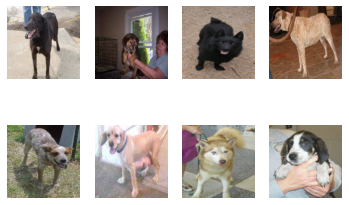

In [9]:
col = 4
row = 2

fig = plt.figure()
for index in range(1, col*row + 1):
  plt.subplot(row, col, index)
  plt.axis('off')
  plt.imshow(cv2.resize(cv2.cvtColor(cv2.imread(transformed_train_data.list_images_path[index+19]), cv2.COLOR_BGR2RGB), (224, 224)))

In [10]:
train_data_loader = DataLoader(transformed_train_data, batch_size=32, shuffle=True)
test_data_loader = DataLoader(transformed_test_data, batch_size=32, shuffle=True)

# VGG

In [11]:
class VGG16(nn.Module):
    def __init__(self, n_classes=2):
        super(VGG16, self).__init__()

        self.feature_extractor = nn.Sequential(
            self.create_conv_block([3, 64], [64, 64], [3, 3], [1, 1], 2, 2),
            self.create_conv_block([64, 128], [128, 128], [3, 3], [1, 1], 2, 2),
            self.create_conv_block([128, 256, 256], [256, 256, 256], [3, 3, 3], [1, 1, 1], 2, 2),
            self.create_conv_block([256, 512, 512], [512, 512, 512], [3, 3, 3], [1, 1, 1], 2, 2),
            self.create_conv_block([512, 512, 512], [512, 512, 512], [3, 3, 3], [1, 1, 1], 2, 2),
        )

        self.flatten = nn.Flatten() 

        self.FC_layer = nn.Sequential(
            self.create_fc_layer(7*7*512, 1028),
            self.create_fc_layer(1028, 512),
        )

        self.classifier = nn.Linear(in_features=512, out_features=n_classes)
    
    def forward(self, x):
        output = self.feature_extractor(x)
        output = self.flatten(output)
        output = self.FC_layer(output)
        output = self.classifier(output)

        return output

    
    def create_conv_layer(self, chann_in, chann_out, kernel_size, padding_size):
        layer = nn.Sequential(
            nn.Conv2d(chann_in, chann_out, kernel_size=kernel_size, padding=padding_size),
            nn.BatchNorm2d(chann_out),
            nn.ReLU()
        )

        return layer 
    
    def create_conv_block(self, list_chann_in, list_chann_out, list_kernel_size, list_padding_size, pooling_kernel, pooling_Stride):
        layers = [self.create_conv_layer(list_chann_in[i], list_chann_out[i], list_kernel_size[i], list_padding_size[i])
                    for i in range(len(list_chann_in))]
        
        layers += [nn.MaxPool2d(kernel_size=pooling_kernel, stride=pooling_Stride)]

        return nn.Sequential(*layers)
    
    def create_fc_layer(self, chann_in, chann_out):
        layer = nn.Sequential(
            nn.Linear(chann_in, chann_out),
            nn.ReLU()
        )

        return layer

In [12]:
model = VGG16(2).to(device)

In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss_function = nn.CrossEntropyLoss()

# Train 

In [14]:
'''
    Function for computing the accuracy of the predictions over the entire data_loader
'''
def get_accuracy(model, data_loader, device):
    correct = 0
    total = 0
    
    with torch.no_grad():
        model.eval()
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100*(correct/total)

'''
    Function for plotting training and validation losses
'''
def plot_losses(train_acc, valid_acc):
    # change the style of the plots to seaborn
    plt.style.use('seaborn')

    train_acc = np.array(train_acc)
    valid_acc = np.array(valid_acc)

    fig, ax = plt.subplots(figsize=(8, 4.5))

    ax.plot(train_acc, color="blue", label="Train_acc")
    ax.plot(valid_acc, color="red", label="Validation_acc")
    ax.set(title="Acc over epochs",
            xlabel="Epoch",
            ylabel="Acc")
    ax.legend()
    fig.show()

  # change the plot style to default
    plt.style.use('default')

'''
    function for the training step of the training loop
'''
def train(train_loader, model, criterion, optimizer, device):
    model.train()
    running_loss = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        # backward and optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = running_loss / len(train_loader)

    return model, optimizer, epoch_loss 

'''
    function for the validation step of the training loop
'''
def validate(valid_loader, model, criterion, device):
    model.eval()
    running_loss = 0

    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)

        # forward pass and record loss
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(valid_loader)

    return model, epoch_loss

'''
    function defining the entire training loop
'''
def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    # set object for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
    list_train_acc = []
    list_val_acc = []

    # train model
    for epoch in range(0, epochs):
        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)

        if epoch % print_every == print_every - 1:
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)


            print('Epochs: {}, Train_loss: {}, Valid_loss: {}, Train_accuracy: {}, Valid_accuracy: {}'.format(
                    epoch, train_loss, valid_loss, train_acc, valid_acc
                    ))

            list_train_acc.append(train_acc)
            list_val_acc.append(valid_acc)
            train_losses.append(train_loss)
            valid_losses.append(valid_loss)

    plot_losses(list_train_acc, list_val_acc)

    return model, optimizer, (train_losses, valid_losses)

In [ ]:
model, optimizer, _ = training_loop(model, loss_function, optimizer, train_data_loader, test_data_loader, 5, device)

/usr/local/lib/python3.7/dist-packages/imgaug/augmenters/segmentation.py:191: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  segments = segmentation.slic(image, n_segments=n_segments_samples[i], compactness=10)
